# Measuring the effects of axonal adaptations on firing properties of Mitral Cells

I will use experimental data and data from the literature to develop a realistic mitral cell with myelinated axonal domains to determine how changes and adaptations in these domains influence action potential initiation and propagation. 

## Model design
This mitral cell model was implemented and simulated using the Python 3.8 bindings to the NEURON 7.7 simulation environment.
I used an object oriented approach to simplify making changes to the model and running different experiments. Model changes relevant to experiments (voltage gated ion channel conductance between runs etc.) are also tested (see `python/tests/`)

Important model components are described below.

### AIS

The axon initial segment was designed with Na<sub>v</sub>1.6, Na<sub>v</sub>1.2, K<sub>v</sub>, and passive leak channels. The AIS in cortex displays dramatic ion channel distribution changes along its length ([Hu et al. 2009; Figure 6](https://www.nature.com/articles/nn.2359))
<div  style="float:right">
<img src="img/Hu_Shu_2009_fig5.png" alt="Hu et al. 2009" width=450/>
</div>
While I could not find precise numbers for this experiment, it appears that Na<sub>v</sub>1.6 channel density increase monotonically from 0 to 2,000$pS \mu{}m^{-2}$ with a rate of $50pS\mu{}m^{-1}$, reaching the peak ~ halfway down the axon and staying constant until termination. Na<sub>v</sub>1.2 channels decrease at about the same rate from a peak of density of 2500 to a minimum of 0$pS \mu{}m^{-2}$ ~ 67% down the AIS. 

For simplicity, I made a simple function to setup these gradients with linear steps from some minimum to some maximum based on the number of segments I used to represent the AIS. 




```python

def simple_ais_channel_gradient(self, gmap):
    """temporary method. Uses a linear increase or decrease of channel density based on nseg. 
    Need to make it more realistic based on Hu et al. 2009 Figure 5"""
    a = np.linspace(gmap["min"], gmap["max"], self.ais.nseg)
    if gmap["reverse"] == True:
        return a[::-1]
    return a

```
Where `gmap` is a dictionary/map containing the keys `min`, `max`, and `reverse`. This function is used to generate a range of numbers representing the conductance changes along the AIS from `min` to `max` in `nseg` number of steps (default `nseg` is 15 for the AIS). The generated distribution is then applied to the AIS with this method:

```python

def _ais_biophysics(self):
    """setup biophysics for ais. Channel distributions will be defined as gradients along segments."""
    self.ais.insert("na12")
    self.ais.insert("na16")
    self.ais.insert("kv")
    self.ais.insert("kd")
    na12_gradient = self.simple_ais_channel_gradient(self.gnav12_dist)
    na16_gradient = self.simple_ais_channel_gradient(self.gnav16_dist)
    for ind, seg in enumerate(self.ais):
        seg.gbar_na16 = na16_gradient[ind]
        seg.gbar_kd = 0
        seg.gbar_kv = self.ais_kv_gbar
    for ind, seg in enumerate(self.ais):
        seg.gbar_na12 = na12_gradient[ind]

```

### Myelin sheath

[Zbili et al. 2020](https://www.frontiersin.org/articles/10.3389/fncel.2020.00040/full) modeled the myelin membrane using the `extracellular` mechanism to add another layer of RC circuit to the internodes (Zbili et al. 2020 Sup. Fig 3):

<img src="img/sup_fig_3_zbili2020.jpg" alt="Zbili et al. 2020" width=800/>


Passive conductance of G<sub>my</sub> and C<sub>my</sub> depend on the number of myelinated wraps, and since each "wrap" is a bilayer, relative to the axon each sheath halves the G and C:

G<sub>my</sub>= G<sub>ax</sub>/2 and C<sub>my</sub>=C<sub>ax</sub>/2. 

Using a high magnification image from the lateral olfactory tract (LOT), I can count ~16 wraps spanning 173nm. 
<div  style="float:right">
<img src="img/HM_myelin_sheath.png" alt="LOT myelin sheath, unpublished data NMG" width=450/>
</div>

I implemented the myelin sheath based closely on the [published model](https://senselab.med.yale.edu/ModelDB/showmodel?model=263053&file=/zbili_debanne/myelinated_axon_1.hoc#tabs-2) ([Zbili et al. 2020](https://www.frontiersin.org/articles/10.3389/fncel.2020.00040/full)):

```python


def _myelinated_segments_biophysics(self):
    for myelin_section in self.myelinated_segs_list:
        myelin_section.insert("extracellular")
        myelin_section.xraxial[0] = 120663
        myelin_section.xraxial[1] = 10000000000
        myelin_section.xg[0] = 0.0000333 / (self.n_myelin_wraps * 2)
        myelin_section.xg[1] = 10000000000
        myelin_section.xc[0] = 1 / (self.n_myelin_wraps * 2)
        myelin_section.xc[1] = 0.0000000001
        myelin_section.e_extracellular = 0
        myelin_section.Ra = 150
        for myelin_seg in myelin_section:
            myelin_seg.cm = 0.012
            myelin_seg.g_pas = 1 / 100000

```

**Disclaimer:** From the [documentation](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html):

    Extracellular potentials do a great deal of violence to one’s intuition and it is important that the user carefully consider the results of simulations that use them. It is best to start out believing that there are bugs in the method and attempt to prove their existence.
**I have not done that.**


## Nodes of Ranvier

Nodes of Ranvier are composed of 3 segments (`nseg`) and contain the biophysics are implemented like so:
```python
def _node_biophysics(self):
    for node_section in self.nodes_list:
        node_section.insert("na16")
        node_section.insert("kd")
        node_section.insert("kv")
        node_section.Ra = 150
        node_section.cm = 1
        for node_seg in node_section:
            node_seg.g_pas = 0.0000333
            node_seg.gbar_na16 = self.node_gbar_na16
            node_seg.ena = 60
            node_seg.gbar_kd = self.node_gbar_kd
            node_seg.gbar_kv = self.node_gbar_kv
            node_seg.ek = -90
            node_seg.e_pas = -38.3
```


# How does AIS length affect AP firing properties in a Model of a mitral cell?

In [1]:
import sys
import scipy.signal as s
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
sys.path.insert(0,"../mitral_cell/")
from neuron import h
# custom modules
from mitralcell import MitralCell
import actionpotential as ap


mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.linewidth']= 1
mpl.rcParams['axes.titleweight']= 'normal'

h.nrn_load_dll("../../nmodl/x86_64/.libs/libnrnmech.so")
cell = MitralCell("1", nodes=5)

CMAP = "viridis"
def make_cmap(time_v, cmap):
    lt = len(time_v)
    print(lt)
    cm = plt.get_cmap(cmap, lt)
    return [cm(i/(lt+1)) for i in range(lt)]
    

In [2]:
h.topology()



|---|       soma(0-1)
     `--------------|       ais(0-1)
                     `---------|       myelin_seg_0(0-1)
                                `--|       node_0(0-1)
                                    `---------|       myelin_seg_1(0-1)
                                               `--|       node_1(0-1)
                                                   `---------|       myelin_seg_2(0-1)
                                                              `--|       node_2(0-1)
                                                                  `---------|       myelin_seg_3(0-1)
                                                                             `--|       node_3(0-1)
                                                                                 `---------|       myelin_seg_4(0-1)
                                                                                            `--|       node_4(0-1)
                                                                                

1.0

# Running experiments

To run batch experiments, I use python's dictionary datastructure to set all the relevant experimental parameters. Dictionaries are flexible, easy to parse, and easy to represent as JSON for serialization and documentation. 
The dictionary would look like this:
```python
stim_details = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.07,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

```

and would be passed to a special method defined in my cell which parses the experiment details, and runs the experiment. 

`thing_to_stim` and `loc` defines where the **IClamp** will be placed for stimulation, and `recording_vectors` holds a dictionary of **NEURON** vectors for recording from different locations. A time vector is automatically recorded and returned.
After the experiment is run, this same data structure is returned with the results in the `recording_vectors` dictionary. 

## For example, here I will run a simple IV experiment


In [3]:
stim_details = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.07,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais_data = []
soma_data = []
time_vectors = []
amplitudes = []

for amp in np.arange(-0.025,0.3,0.025):
    amplitudes.append(amp) # record amplitude
    stim_details['amp'] = amp # set amplitude in experiment dictionary
    stim_details['recording_vectors']['soma'] = h.Vector().record(cell.soma(0.5)._ref_v) # record from soma
    stim_details['recording_vectors']['ais'] = h.Vector().record(cell.ais(0.5)._ref_v) # record from AIS
    cell.add_stim(stim_details) # load and set experiment metadata to run
    res = cell.run() # run experiment
    ais_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors

## Now I can plot the results of the IV experiment.

13


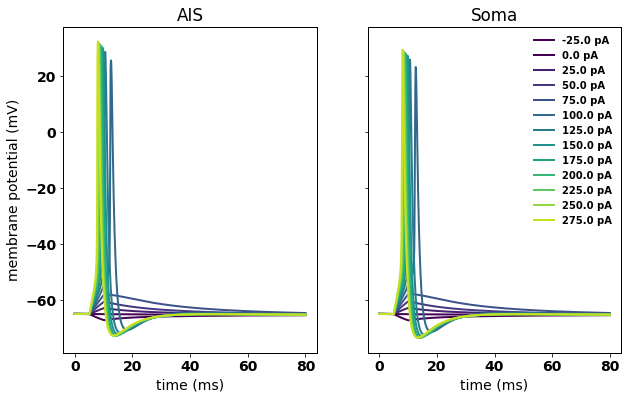

In [4]:
colors = make_cmap(time_vectors, CMAP)

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=True)
for time, ais, soma, amp, clr in zip(time_vectors, ais_data, soma_data, amplitudes, colors):    
    ax1.plot(time, ais, color=clr)
    ax2.plot(time, soma, color=clr, 
             label = f"{np.round(amp*1000, 2)} pA")
    
ax1.set_title("AIS")
ax1.set_ylabel("membrane potential (mV)")
ax1.set_xlabel("time (ms)")
ax2.set_xlabel("time (ms)")
ax2.set_title("Soma")

ax2.legend()

# IV and AP shape Analysis 

In [5]:
ais_amps = ap.ap_batch_amplitude(ais_data, stim_details['rmp'])
soma_amps = ap.ap_batch_amplitude(soma_data, stim_details['rmp'])
ais_fwhms = ap.ap_batch_fwhm(time_vectors, ais_data, stim_details['rmp']) 
soma_fwhms = ap.ap_batch_fwhm(time_vectors, soma_data, stim_details['rmp']) 
pa_amps = [i*1000 for i in amplitudes]

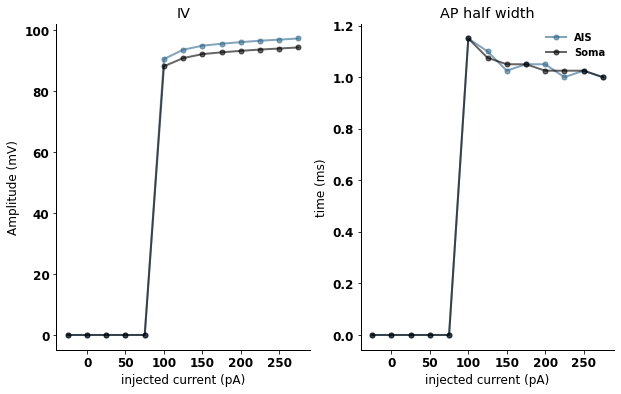

In [6]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(pa_amps, ais_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(pa_amps, soma_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax2.plot(pa_amps, ais_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(pa_amps, soma_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)
ax1.set_title("IV")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("injected current (pA)")
ax2.set_xlabel("injected current (pA)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# How does AIS length affect amplitude?

Here I am just changing AIS length while keeping channel distributions the same

In [7]:
cell2 = MitralCell("2", nodes=5)

In [8]:
stim_details_len = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.08,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais_data = []
soma_data = []
time_vectors = []
lengths = []

for length in np.arange(30,70,5):
    lengths.append(length) 
    cell2.ais.L = length
    stim_details_len['recording_vectors']['soma'] = h.Vector().record(cell2.soma(0.5)._ref_v) # record from soma
    stim_details_len['recording_vectors']['ais'] = h.Vector().record(cell2.ais(0.5)._ref_v) # record from AIS
    cell2.add_stim(stim_details_len)
    res = cell2.run() # run experiment
    ais_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors

8


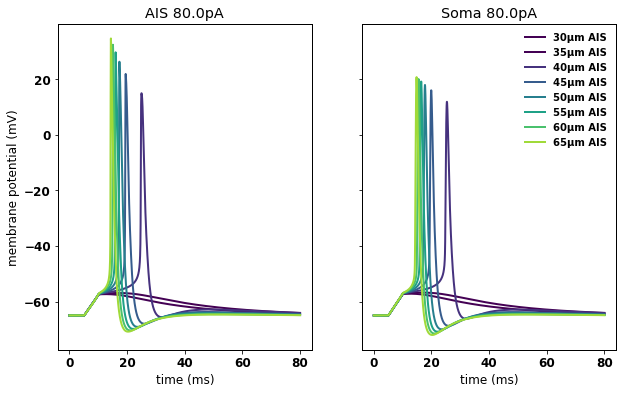

In [9]:
gnuplot2clrs = make_cmap(time_vectors, CMAP)
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=True)
for time, ais, soma, length, col in zip(time_vectors, ais_data, soma_data, lengths, gnuplot2clrs):    
    ax1.plot(time, ais, color=col)
    ax2.plot(time, soma, color=col, label=f"{length}\u00B5m AIS")
    
ax1.set_title(f"AIS {stim_details_len['amp']*1000}pA")
ax1.set_ylabel("membrane potential (mV)")
ax1.set_xlabel("time (ms)")
ax2.set_xlabel("time (ms)")
ax2.set_title(f"Soma {stim_details_len['amp']*1000}pA")

ax2.legend()

In [10]:
ais_len_amps = ap.ap_batch_amplitude(ais_data, stim_details['rmp'])
soma_len_amps = ap.ap_batch_amplitude(soma_data, stim_details['rmp'])
ais_len_fwhms = ap.ap_batch_fwhm(time_vectors, ais_data, stim_details['rmp']) 
soma_len_fwhms = ap.ap_batch_fwhm(time_vectors, soma_data, stim_details['rmp']) 

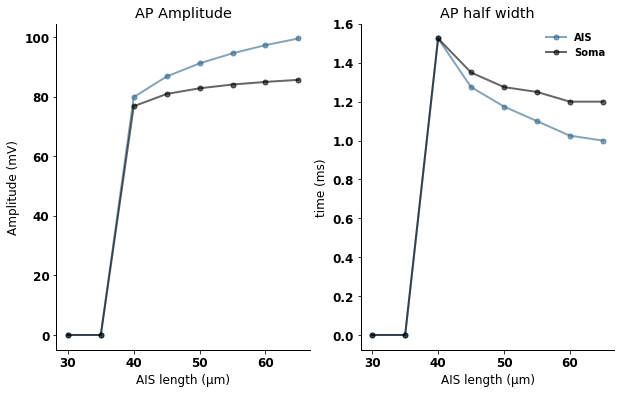

In [11]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(lengths, ais_len_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(lengths, soma_len_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax2.plot(lengths, ais_len_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(lengths, soma_len_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)
ax1.set_title("AP Amplitude")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("AIS length (\u00B5m)")
ax2.set_xlabel("AIS length (\u00B5m)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# TODO:
1. Node AP propagation (FWHM) as it travels down nodes. 
1. sample from known lengths and compare

In [12]:
stim_details_cond = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.08,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais16_data = []
soma16_data = []
time_vectors = []
cond_maxs = []

cell2.gnav16_dist['max'] = 2500
cell2.gnav12_dist['max'] = 2000
cell2.setup_biophysics()

for nav16max in np.arange(0,6000,500):
    cond_maxs.append(nav16max) 
    cell2.gnav16_dist['max'] = nav16max
    stim_details_cond['recording_vectors']['soma'] = h.Vector().record(cell2.soma(0.5)._ref_v) # record from soma
    stim_details_cond['recording_vectors']['ais'] = h.Vector().record(cell2.ais(0.5)._ref_v) # record from AIS
    cell2.add_stim(stim_details_cond)
    res = cell2.run() # run experiment
    ais16_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma16_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors
    
ais16_cond_amps = ap.ap_batch_amplitude(ais16_data, stim_details['rmp'])
soma16_cond_amps = ap.ap_batch_amplitude(soma16_data, stim_details['rmp'])
ais16_cond_fwhms = ap.ap_batch_fwhm(time_vectors, ais16_data, stim_details_cond['rmp']) 
soma16_cond_fwhms = ap.ap_batch_fwhm(time_vectors, soma16_data, stim_details_cond['rmp']) 

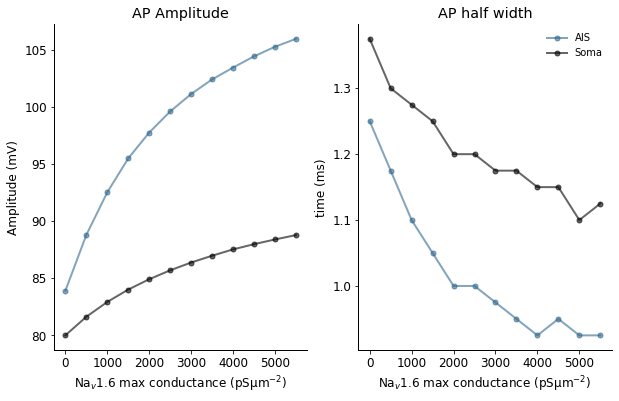

In [13]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['mathtext.bf']= 'none'
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(cond_maxs, ais16_cond_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(cond_maxs, soma16_cond_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais16_cond_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, soma16_cond_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)
ax1.set_title("AP Amplitude")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("Na$_{v}$1.6 max conductance (pS\u00B5m$^{-2}$)")
ax2.set_xlabel("Na$_{v}$1.6 max conductance (pS\u00B5m$^{-2}$)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

In [14]:
stim_details_cond = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.08,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais12_data = []
soma12_data = []
time_vectors = []
cond_maxs = []

cell2.gnav16_dist['max'] = 2500
cell2.gnav12_dist['max'] = 2000
cell2.setup_biophysics()

for nav12max in np.arange(0,6000,500):
    cond_maxs.append(nav12max) 
    cell2.gnav12_dist['max'] = nav12max
    stim_details_cond['recording_vectors']['soma'] = h.Vector().record(cell2.soma(0.5)._ref_v) # record from soma
    stim_details_cond['recording_vectors']['ais'] = h.Vector().record(cell2.ais(0.5)._ref_v) # record from AIS
    cell2.add_stim(stim_details_cond)
    res = cell2.run() # run experiment
    ais12_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma12_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors
    
ais12_cond_amps = ap.ap_batch_amplitude(ais12_data, stim_details_cond['rmp'])
soma12_cond_amps = ap.ap_batch_amplitude(soma12_data, stim_details_cond['rmp'])
ais12_cond_fwhms = ap.ap_batch_fwhm(time_vectors, ais12_data, stim_details_cond['rmp']) 
soma12_cond_fwhms = ap.ap_batch_fwhm(time_vectors, soma12_data, stim_details_cond['rmp']) 

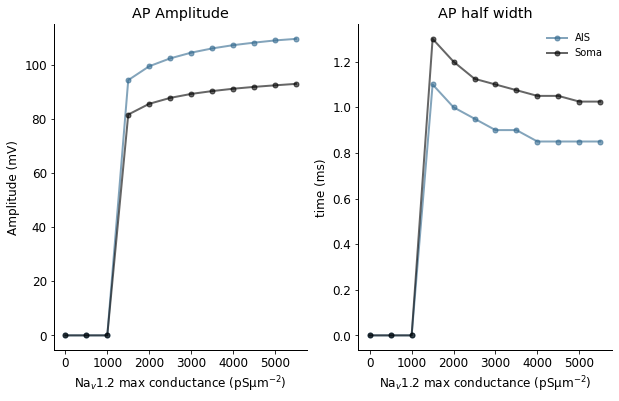

In [15]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['mathtext.bf']= 'none'
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(cond_maxs, ais12_cond_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(cond_maxs, soma12_cond_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais12_cond_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, soma12_cond_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)
ax1.set_title("AP Amplitude")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("Na$_{v}$1.2 max conductance (pS\u00B5m$^{-2}$)")
ax2.set_xlabel("Na$_{v}$1.2 max conductance (pS\u00B5m$^{-2}$)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

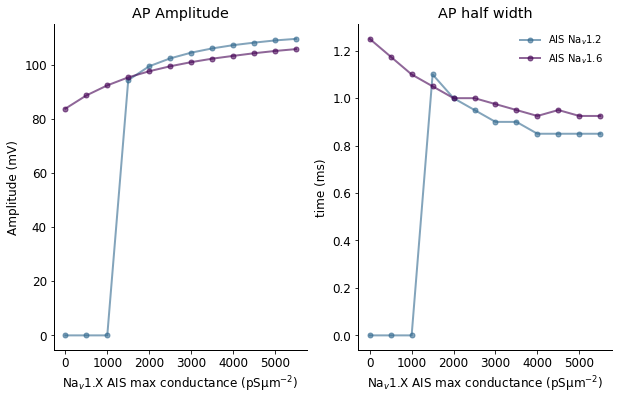

In [16]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['mathtext.bf']= 'none'

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(cond_maxs, ais12_cond_amps, label= "AIS Na$_{v}$1.2", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(cond_maxs, ais16_cond_amps, label= "AIS Na$_{v}$1.6", color=colors[0], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais12_cond_fwhms, label = "AIS Na$_{v}$1.2", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais16_cond_fwhms, label = "AIS Na$_{v}$1.6", color=colors[0], marker=".", markersize=10, alpha=0.6)

ax1.set_title("AP Amplitude")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("Na$_{v}$1.X AIS max conductance (pS\u00B5m$^{-2}$)")
ax2.set_xlabel("Na$_{v}$1.X AIS max conductance (pS\u00B5m$^{-2}$)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

Increasing both together

In [17]:

stim_details_cond = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.08,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais1216_data = []
soma1216_data = []
time_vectors = []
cond_maxs = []
cell2.gnav16_dist['max'] = 2500
cell2.gnav12_dist['max'] = 2000
cell2.setup_biophysics()

for nav12max in np.arange(0,6000,500):
    cond_maxs.append(nav12max) 
    cell2.gnav12_dist['max'] = nav12max
    cell2.gnav16_dist['max'] = nav12max
    stim_details_cond['recording_vectors']['soma'] = h.Vector().record(cell2.soma(0.5)._ref_v) # record from soma
    stim_details_cond['recording_vectors']['ais'] = h.Vector().record(cell2.ais(0.5)._ref_v) # record from AIS
    cell2.add_stim(stim_details_cond)
    res = cell2.run() # run experiment
    ais1216_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma1216_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors
    
ais1216_cond_amps = ap.ap_batch_amplitude(ais1216_data, stim_details_cond['rmp'])
soma1216_cond_amps = ap.ap_batch_amplitude(soma1216_data, stim_details_cond['rmp'])
ais1216_cond_fwhms = ap.ap_batch_fwhm(time_vectors, ais1216_data, stim_details_cond['rmp']) 
soma1216_cond_fwhms = ap.ap_batch_fwhm(time_vectors, soma1216_data, stim_details_cond['rmp']) 

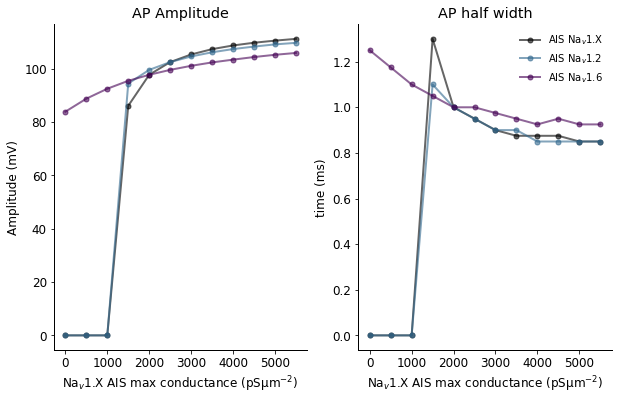

In [18]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['mathtext.bf']= 'none'

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(cond_maxs, ais1216_cond_amps, label= "AIS Na$_{v}$1.X", color='black', marker=".", markersize=10, alpha=0.6)
ax1.plot(cond_maxs, ais12_cond_amps, label= "AIS Na$_{v}$1.2", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(cond_maxs, ais16_cond_amps, label= "AIS Na$_{v}$1.6", color=colors[0], marker=".", markersize=10, alpha=0.6)

ax2.plot(cond_maxs, ais1216_cond_fwhms, label = "AIS Na$_{v}$1.X", color='black', marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais12_cond_fwhms, label = "AIS Na$_{v}$1.2", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais16_cond_fwhms, label = "AIS Na$_{v}$1.6", color=colors[0], marker=".", markersize=10, alpha=0.6)

ax1.set_title("AP Amplitude")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("Na$_{v}$1.X AIS max conductance (pS\u00B5m$^{-2}$)")
ax2.set_xlabel("Na$_{v}$1.X AIS max conductance (pS\u00B5m$^{-2}$)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)